In [1]:
# Import the classes.
from analysis.timing.graph import *
from analysis.timing.entities import *

# Import the timing analysis functions.
import analysis.timing.timing_analysis as analysis


In [2]:
# Set the logging level.
analysis.set_logger_level(analysis.logging.ERROR)


# Network Support

In [3]:
class Device(Node):
    """The device extends node from the graph library.
    """
    def __init__(self, id: int, entities: List[Entity], base_delay: float = 0):
        """It takes as input the unique id, and the list of entities.
        Args:
            id (int): The unique id.
            entities (List[Entity]): The list of entities.
            base_delay (_type_, optional): Base software delay. Defaults to 0.
        """
        Node.__init__(self, id)
        self.entities = entities
        self.base_delay = base_delay

    def device_delay(self) -> float:
        return len(self.entities) * self.base_delay

def device_to_device_delay(graph: Graph, source: Device, target: Device) -> float:
    """Get the delay between every node.

    Args:
        source (Device): Source device.
        target (Device): Target device.

    Returns:
        float: The delay between the nodes.
    """
    if source == target:
        return 0
    (weight, _) = graph.find_shortest_path(source, target)
    return source.device_delay() + weight + target.device_delay()


# Scenario (SOME/IP)

In [4]:
# Load the services.
S0 = Service("S0", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S1 = Service("S1", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S2 = Service("S2", boot_del=4, init_del=6, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S3 = Service("S3", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S4 = Service("S4", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)

# Load the clients.
C0 = Client("C0", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C1 = Client("C1", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C2 = Client("C2", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C3 = Client("C3", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C4 = Client("C4", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C5 = Client("C5", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)


# Scenario (Graph)

In [5]:
# Place services and clients inside nodes.
n0 = Device(id = 0, entities = [S0, C0, C1], base_delay = 0.05)
n1 = Device(id = 1, entities = [S1, S2],     base_delay = 0.025)
n2 = Device(id = 2, entities = [S3, C2, C3], base_delay = 0.075)
n3 = Device(id = 3, entities = [S4, C4],     base_delay = 0.045)
n4 = Device(id = 4, entities = [C5],         base_delay = 0.076)

# Create the graph, using weights computed using the following formula:
#   (frame_length * 8) / link_speed
# 
G = Graph(
    connections = [
        (n0, n1, lambda graph, node0, node1: ( 256 * 8) / 1e09),
        (n1, n2, lambda graph, node0, node1: ( 256 * 8) / 1e06),
        (n1, n3, lambda graph, node0, node1: (1024 * 8) / 1e03),
        (n3, n4, lambda graph, node0, node1: ( 256 * 8) / 1e09),
        (n2, n3, lambda graph, node0, node1: ( 256 * 8) / 1e06),
        (n2, n4, lambda graph, node0, node1: (1024 * 8) / 1e03)
    ],
    directed = False
)


# Visualize the graph

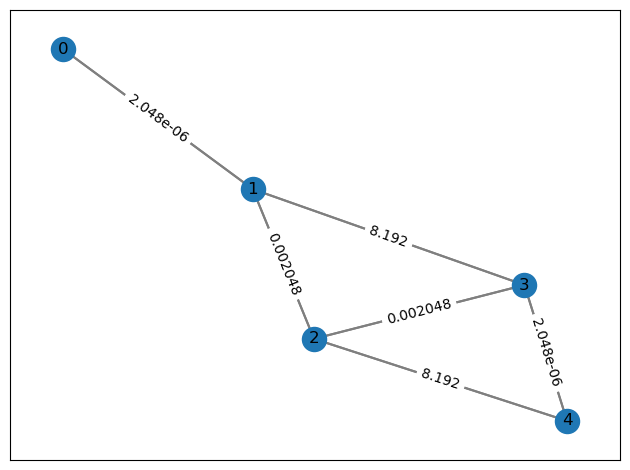

In [6]:
G.plot_graph()

# Compute timing analysis

In [7]:
# Check where the SOME/IP entities are located.
containing_node = {}
for node in G.graph:
    for entity in node.entities:
        containing_node[entity] = node

def create_relation(graph: Graph, e0: Entity, e1: Entity) -> Relation:
    """Creates a relation between the pair of entities.

    Args:
        graph (Graph): The graph.
        e0 (Entity): The first entity.
        e1 (Entity): The second entity.

    Returns:
        Relation: A relation between the entities.
    """
    return Relation(e0, e1, device_to_device_delay(graph, containing_node[e0], containing_node[e1]))

# Define the relations between clients and services.
system = [
    create_relation(G, C0, S3),
    create_relation(G, C0, S4),
    create_relation(G, C1, S0),
    create_relation(G, C2, S4),
    create_relation(G, C3, S4),
    create_relation(G, C3, S0),
    create_relation(G, C4, S1),
    create_relation(G, C5, S0)
]

# Compute the worst-case discovery time.
analysis.timing_analysis_system(system)


14.420050048000002

# Graph to CSV

In [9]:
# We save the current graph.
Graph.write_to_csv(G, "test.csv")
# We load the graph from file.
G1 = Graph.read_from_csv("test.csv")
print(G)
print(G1)

[(0, 1, 2.048e-06), (1, 0, 2.048e-06), (1, 2, 0.002048), (1, 3, 8.192), (2, 1, 0.002048), (2, 3, 0.002048), (2, 4, 8.192), (3, 1, 8.192), (3, 2, 0.002048), (3, 4, 2.048e-06), (4, 2, 8.192), (4, 3, 2.048e-06)]
[(0, 1, 2.048e-06), (1, 3, 2.048e-06), (1, 2, 2.048e-06), (1, 0, 2.048e-06), (2, 3, 2.048e-06), (2, 4, 2.048e-06), (2, 1, 2.048e-06), (3, 4, 2.048e-06), (3, 2, 2.048e-06), (3, 1, 2.048e-06), (4, 3, 2.048e-06), (4, 2, 2.048e-06)]
